# 1. Data preprocessing

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [32]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Build model

In [33]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 56 * 56, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 56 * 56)
        x = self.fc(x)
        return x

In [34]:
model = SimpleCNN()

# 3. Train

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [36]:
losses = []
for epoch in  range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 1.8038
Epoch [2/10], Loss: 0.6917
Epoch [3/10], Loss: 0.6612
Epoch [4/10], Loss: 0.6104
Epoch [5/10], Loss: 0.5292
Epoch [6/10], Loss: 0.3999
Epoch [7/10], Loss: 0.2668
Epoch [8/10], Loss: 0.1292
Epoch [9/10], Loss: 0.0392
Epoch [10/10], Loss: 0.0157


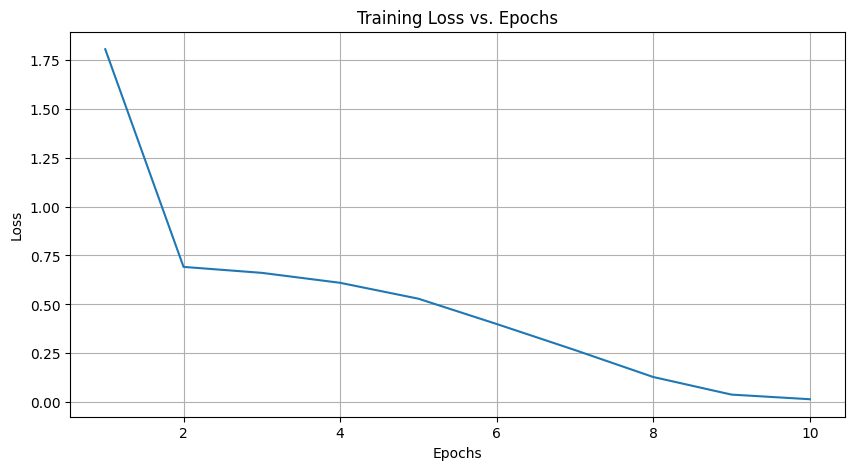

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 4. Evaluation

In [38]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [39]:
correct = 0
total = 0

In [40]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 61.67%


In [41]:
# model complexity (number of parameters)
def profile_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params
params = profile_params(model)
print(f"Parameters: {params}")

Parameters: (12850530, 12850530)


In [42]:
# computation complexity (number of FLOPs)
def profile_flops(model, input):
    class FLOPCounter(nn.Module):
        def __init__(self, model):
            super(FLOPCounter, self).__init__()
            self.model = model
            self.total_flops = 0
            self.hooker()

        def hooker(self):
            def hook(module, input, output):
                flops = 1
                for s in list(output.size())[1:]:
                    flops *= s
                for s in list(input[0].size())[1:]:
                    flops *= s
                self.total_flops += flops

            for module in self.model.modules():
                if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                    module.register_forward_hook(hook)

        def forward(self, x):
            self.total_flops = 0
            self.model(x)
            return self.total_flops

    flops_counter = FLOPCounter(model)
    flops = flops_counter(input)
    return flops
flops = profile_flops(model, input=torch.randn(1, 3, 224, 224))
print(f"FLOPs: {flops}")

FLOPs: 201423323392
